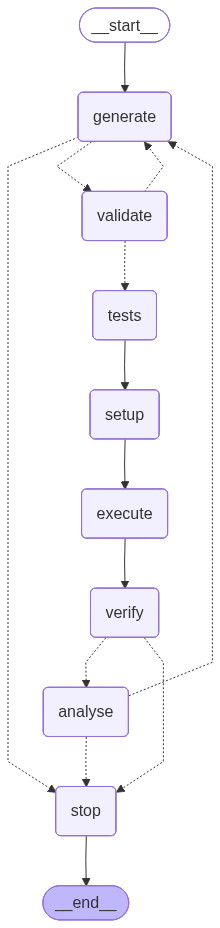

In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from pydantic import BaseModel, Field
from rich.pretty import pprint
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import tempfile
import subprocess
from datetime import datetime
import json
from typing import TypedDict, Annotated, NotRequired, Literal
import operator
from enum import Enum
import logging


logger = logging.getLogger("bash_script_agent")
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)


load_dotenv()

MODEL = os.getenv("MODEL", "gemini-2.5-flash")
BASE_URL = os.getenv("BASE_URL")
API_KEY = os.getenv("GEMINI_API_KEY")

rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.1,
    check_every_n_seconds=5,
    max_bucket_size=100,
)

llm = ChatOpenAI(
    model=MODEL,
    api_key=API_KEY,  # type: ignore
    base_url=BASE_URL,
    temperature=0,
    rate_limiter=rate_limiter,
)


@tool
def run_command(command: str, timeout: int = 30) -> dict:
    """
    Execute a shell command to verify its behavior, output format, or availability.

    Use this tool when you need to:
    1. Verify the OUTPUT FORMAT of a command before using it in the script
       Example: Check how 'df -h' formats columns on this system
    2. Check if a specific command/utility is available
       Example: 'which jq' or 'command -v nc'
    3. Test command flags/options compatibility
       Example: Does 'date' support '+%s' on this system?
    4. Understand system-specific command behavior
       Example: How does 'ps' format output here?
    5. Debug why a command in the script is failing

    DO NOT use for:
    - Testing the actual script logic (that's done separately)
    - Checking extremely common POSIX utilities (echo, cat, grep basics)

    Args:
        command: The shell command to execute (e.g., 'date +%Y-%m-%d')
        timeout: Maximum execution time in seconds (default: 10)

    Returns:
        Dictionary with stdout, stderr, exit_code, and success status
    """
    try:
        result = subprocess.run(
            command, shell=True, capture_output=True, text=True, timeout=timeout
        )

        return {
            "stdout": result.stdout,
            "stderr": result.stderr,
            "exit_code": result.returncode,
            "success": result.returncode == 0,
            "command": command,
        }
    except subprocess.TimeoutExpired:
        return {
            "stdout": "",
            "stderr": f"Command timed out after {timeout} seconds",
            "exit_code": -1,
            "success": False,
            "command": command,
        }
    except Exception as e:
        return {
            "stdout": "",
            "stderr": f"Error executing command: {str(e)}",
            "exit_code": -1,
            "success": False,
            "command": command,
        }


# Create tool node
tools = [run_command]
tool_node = ToolNode(tools)


def clean_script(script: str) -> str:
    if script.startswith("```bash"):
        script = script[len("```bash") :].strip()
    if script.endswith("```"):
        script = script[: -len("```")].strip()
    return script


def save_script(script: str, name: str):
    with open(name, "w") as f:
        f.write(script)
    os.chmod(name, 0o755)


def create_bash_script(
    request: str, review: str | None = None, prev_script: str | None = None
) -> str:
    if review is None:
        SYSTEM_PROMPT = """You are an expert bash script developer. Generate robust, production-quality bash scripts.

Your scripts must:
1. Start with #!/usr/bin/env bash
2. Include error handling (set -euo pipefail)
3. Don't write any comments or explanations
4. Validate inputs
5. Use proper quoting for variables
6. Include helpful usage messages
7. Handle edge cases gracefully
8. Use functions for better organization
9. Return appropriate exit codes

Generate ONLY the bash script, no explanations before or after.
"""
        HUMAN_PROMPT = f"""Generate a bash script that: {request}

Make it robust, secure, and production-ready.
"""

        response = llm.invoke(
            [SystemMessage(content=SYSTEM_PROMPT), HumanMessage(content=HUMAN_PROMPT)]
        )
        return clean_script(str(response.content))
    else:
        SYSTEM_PROMPT = """You are an expert bash script debugger. Fix the errors in the previous script while maintaining its core functionality. Don't write any comments or explanations

    Analyze the errors carefully and provide a corrected version of the script.
    Generate ONLY the bash script, no explanations before or after."""

        HUMAN_PROMPT = f"""The previous script failed with these errors:

        {review}

        Previous script:
        ```bash
        {prev_script}
        ```

        Fix these errors and generate an improved version."""

        messages = [
            SystemMessage(content=SYSTEM_PROMPT),
            HumanMessage(content=HUMAN_PROMPT),
        ]

        result = llm.invoke(messages)

        return clean_script(str(result.content))


class TestCase(BaseModel):
    id: str
    args: list = Field(
        default_factory=list,
        description="Arguments to be passed to the script in list as you would in the command line.",
    )


class TestCases(BaseModel):
    tests: list[TestCase] = Field(
        ..., description="List of test cases to validate the script."
    )


def generate_test_cases(script: str, user_request: str):
    SYSTEM_PROMPT = """
You are an expert software tester specializing in bash scripts. Given a bash script, generate comprehensive test cases to validate its functionality, robustness, and error handling.


# Instructions:
- Based on the given bash script, user request and summary, generate a set of test cases that cover:
    1. Functional tests to verify the script meets the user request exactly
    2. Edge cases and error handling scenarios
    3. Validation of output format (no headers, only requested data)
- Each test case should include:
    1. A unique identifier.(TC1, TC2, etc.)
    2. Arguments to be passed to the script (if any).
    3. Expected output characteristics

The first test case must always be the expected, working one.
Only generate 5 test cases at most.
"""
    HUMAN_PROMPT = f"""
Generate test cases for the following bash script:

# User Request:
{user_request}

# Script:
{script}

# Instructions:
- Generate a set of test cases that cover:
    1. Functional tests to verify the script meets the user request.
    2. Edge cases and error handling scenarios.
- Each test case should include:
    1. A unique identifier (e.g., TC1, TC2, etc.).
    2. Arguments to be passed to the script (if any).
"""

    response = llm.with_structured_output(TestCases, include_raw=True).invoke(
        [SystemMessage(content=SYSTEM_PROMPT), HumanMessage(content=HUMAN_PROMPT)]
    )

    test_cases = TestCases.model_validate(response["parsed"])

    with open("tests.json", "w") as f:
        f.write(test_cases.model_dump_json())

    _ = input("Check tests and press Enter to continue")

    with open("tests.json", "r") as f:
        test_cases_json = f.read()
        test_cases = TestCases.model_validate_json(test_cases_json)

    os.remove("tests.json")

    return test_cases


def format_test_results(test_results: list[dict], test_cases: TestCases) -> str:
    passed = sum(1 for r in test_results if r["success"])
    total = len(test_results)

    output = []
    output.append(f"TEST SUMMARY: {passed}/{total} passed")

    if passed < total:
        output.append("\nFAILED TESTS:")
        for i, (result, test_case) in enumerate(zip(test_results, test_cases.tests), 1):
            if not result["success"]:
                clean_stderr = result["stderr"].replace(
                    "your 131072x1 screen size is bogus. expect trouble\n", ""
                )
                output.append(
                    f"- {test_case.id} (args: {result['args']}): {clean_stderr}"
                )

    return "\n".join(output)


def execute_bash_script_with_args(
    script_content: str, args: list | None = None, timeout: int = 30
) -> dict:
    import os

    try:
        # Create a temporary file for the script
        with tempfile.NamedTemporaryFile(mode="w", suffix=".sh", delete=False) as f:
            f.write(script_content)
            script_path = f.name

        # Make the script executable
        os.chmod(script_path, 0o755)

        # Prepare command with arguments
        command = ["bash", script_path]
        if args:
            command.extend(args)

        # Execute the script
        start_time = datetime.now()
        result = subprocess.run(
            command, capture_output=True, text=True, timeout=timeout
        )
        execution_time = (datetime.now() - start_time).total_seconds()

        # Clean up
        os.unlink(script_path)

        return {
            "stdout": result.stdout,
            "stderr": result.stderr,
            "exit_code": result.returncode,
            "execution_time": execution_time,
            "success": result.returncode == 0,
            "command": " ".join(command),
            "args_used": args or {},
        }

    except subprocess.TimeoutExpired:
        if "script_path" in locals():
            os.unlink(script_path)
        return {
            "stdout": "",
            "stderr": f"Script execution timed out after {timeout} seconds",
            "exit_code": -1,
            "execution_time": timeout,
            "success": False,
            "command": " ".join(command) if "command" in locals() else "Unknown",
            "args_used": args or {},
        }
    except Exception as e:
        if "script_path" in locals():
            os.unlink(script_path)
        return {
            "stdout": "",
            "stderr": f"Execution error: {str(e)}",
            "exit_code": -1,
            "execution_time": 0,
            "success": False,
            "command": "Unknown",
            "args_used": args or {},
        }


def execute_test_cases(
    script: str, test_cases: list[dict]
) -> tuple[int, int, list[dict]]:
    results = []
    total = len(test_cases)
    passed = 0
    for case in test_cases:
        args = case.get("args", {})

        result = execute_bash_script_with_args(script, args)
        actual_stdout = result["stdout"].strip()
        actual_exit_code = result["exit_code"]

        result_summary = {
            "args": args,
            "stdout": actual_stdout,
            "exit_code": actual_exit_code,
            "success": result["success"],
            "stderr": result["stderr"],
            "execution_time": result["execution_time"],
        }
        if result["success"]:
            passed += 1
        results.append(result_summary)
    return (total, passed, results)


DANGEROUS_PATTERNS = [
    "rm -rf /",
    "rm -rf /*",
    "dd if=/dev/zero",
    "mkfs.",
    "> /dev/sda",
    "wget | sh",
    "curl | sh",
    "fork()",
    ":(){:|:&};:",  # Fork bomb
]


def check_dangerous_patterns(script_content: str) -> list:
    dangerous_found = []
    for pattern in DANGEROUS_PATTERNS:
        if pattern in script_content:
            dangerous_found.append(pattern)
    return dangerous_found


def validate_syntax(script_content: str) -> dict:
    try:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".sh", delete=False) as f:
            f.write(script_content)
            script_path = f.name

        result = subprocess.run(
            ["bash", "-n", script_path], capture_output=True, text=True, timeout=5
        )

        os.unlink(script_path)

        return {
            "valid": result.returncode == 0,
            "errors": result.stderr if result.returncode != 0 else "",
        }

    except Exception as e:
        if "script_path" in locals():
            os.unlink(script_path)
        return {
            "valid": False,
            "errors": f"Validation error: {str(e)}",
        }


def error_analyser(script: str, test_results: str):
    logger.info("Analyzing errors using AI...")
    system_prompt = """You are an expert bash debugger. Analyze the error and provide:
1. Error type (syntax, runtime, logic, permission, dependency, timeout)
2. Root cause
3. Specific fix recommendations
4. Whether the error is fixable

# Tool Access:
You have access to `run_command` for debugging.

**Use run_command when:**
- You need to test a specific command that's failing in the script
- You need to check if a required utility is installed
- You need to verify command output format that's causing parsing issues
- You need to understand system-specific behavior

**Don't use run_command when:**
- The error is clearly a syntax or logic issue you can see in the code
- The error message is self-explanatory
- The fix is straightforward from the test results

Be concise and specific."""

    user_prompt = f"""Analyze this bash script error:

Script:
```bash
{script}
```

{test_results}

Provide structured analysis."""

    messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]

    llm_with_tools = llm.bind_tools(tools, tool_choice="auto")
    response = llm_with_tools.invoke(messages)

    if response.tool_calls:  # type: ignore
        logger.info("Calling tools for error analysis")
        messages.append(response)

        tool_results = tool_node.invoke({"messages": [response]})
        messages.extend(tool_results["messages"])
        message = "### Tool Calls:\n"
        for tool_call, tool_call_result in zip(
            response.tool_calls,  # type: ignore
            tool_results["messages"],
        ):
            message += f"Called Tool: {tool_call['name']}\n"
            message += f"Tool args: {tool_call['args']}\n"
            message += f"Tool result: {tool_call_result.content} \n"
            message += "=" * 50 + "\n"

        logger.info(message)

        final_response = llm.invoke(messages)
        logger.info("Error analysis completed.")
        return final_response.content

    logger.info("Error analysis completed.")
    return response.content


class Result(BaseModel):
    works: bool = Field(..., description="Does the script work as intended?")


def format_test_results_for_verification(test_results: list[dict]) -> str:
    output = []

    success_example = next((r for r in test_results if r["success"]), None)
    if success_example:
        output.append("SUCCESS EXAMPLE:")
        output.append(f"Args: {success_example['args']}")
        output.append(f"Output: {success_example['stdout']}")
        output.append("")

    failure_examples = [r for r in test_results if not r["success"]][:2]
    if failure_examples:
        output.append("FAILURE EXAMPLES:")
        for i, result in enumerate(failure_examples, 1):
            clean_stderr = (
                result["stderr"]
                .replace("your 131072x1 screen size is bogus. expect trouble\n", "")
                .strip()
            )
            output.append(f"{i}. Args: {result['args']}")
            output.append(f"   Exit Code: {result['exit_code']}")
            output.append(f"   Error: {clean_stderr}")
            output.append("")

    return "\n".join(output)


def verify_test_results(script: str, user_request: str, test_results: str) -> Result:
    system_prompt = """You are an expert bash script validator. Based on the test results, determine if the script meets the user request and works as intended.

    Check if it returns expected output for valid inputs and handles errors gracefully for invalid inputs.

    Just return if the script works as intended or not."""

    user_prompt = f"""User Request: {user_request}

Script:
```bash
{script}
```

Test Results:
{test_results}

Does this script work as intended?"""

    response = llm.with_structured_output(Result).invoke(
        [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
    )

    return Result.model_validate(response)


def setup_environment(user_request: str, test_cases: TestCases) -> list[BaseMessage]:
    SYSTEM_PROMPT = """
You are an expert tester who specializes in bash scripts who has access to the `run_command` tool to help you test and validate scripts.

But this is a mock environment that doesn't have any files/folders that are required to test the working of the script.

Your job is to create the proper environment with the required files/folders that are required to test the working of the script.

Also when asked to cleanup the environment backtrack the changes made and undo them accordingly.

# NOTE: Your only job is to create the required files/folders and cleaning them when requested. You don't need to run the tests or validate the script.
"""

    USER_PROMPT = f"""
    Based on the given user request and test cases, create the required files/folders that are required to test the working of the script.

    # User Request:
    {user_request}

    # Test Cases:
    {test_cases.model_dump_json()}
    """

    messages = [SystemMessage(content=SYSTEM_PROMPT), HumanMessage(content=USER_PROMPT)]

    tools = [run_command]
    tool_node = ToolNode(tools)
    llm_with_tools = llm.bind_tools(tools, tool_choice="auto")

    while True:
        response = llm_with_tools.invoke(messages)
        messages.append(response)

        if response.tool_calls:  # type: ignore
            logger.info("Calling tools to create test environment")
            tool_results = tool_node.invoke({"messages": [response]})
            messages.extend(tool_results["messages"])
            message = "### Tool Calls:\n"
            message += "*" * 50 + "\n"
            for tool_call, tool_call_result in zip(
                response.tool_calls,  # type: ignore
                tool_results["messages"],
            ):
                message += f"Called Tool: {tool_call['name']}\n"
                message += f"Tool args: {tool_call['args']}\n"
                message += f"Tool result: {tool_call_result.content} \n"
                message += "=" * 50 + "\n"

            logger.info(message)
        else:
            return messages


def cleanup_env(messages: list[BaseMessage]) -> list[BaseMessage]:
    msg = HumanMessage(
        content="Cleanup the test environment created earlier. Strictly remove any files/folders created based on the previous messages. Use the `run_command` tool to delete files/folders or to undo any changes made."
    )
    messages.append(msg)

    tools = [run_command]
    tool_node = ToolNode(tools)
    llm_with_tools = llm.bind_tools(tools, tool_choice="auto")

    while True:
        response = llm_with_tools.invoke(messages)
        messages.append(response)

        if response.tool_calls:  # type: ignore
            logger.info("Calling tools to create test environment")
            tool_results = tool_node.invoke({"messages": [response]})
            messages.extend(tool_results["messages"])
            message = "### Tool Calls:\n"
            message += "*" * 50 + "\n"
            for tool_call, tool_call_result in zip(
                response.tool_calls,  # type: ignore
                tool_results["messages"],
            ):
                message += f"Called Tool: {tool_call['name']}\n"
                message += f"Tool args: {tool_call['args']}\n"
                message += f"Tool result: {tool_call_result.content} \n"
                message += "=" * 50 + "\n"

            logger.info(message)
        else:
            return messages


class Status(Enum):
    INITIAL = "initial"
    SCRIPT_GENERATED = "script_generated"
    TESTS_GENERATED = "tests_generated"
    TESTS_EXECUTED = "tests_executed"
    REVIEW_GENERATED = "review_generated"
    COMPLETED = "completed"
    FAILED = "failed"
    MAX_ITERATIONS_REACHED = "max_iterations_reached"


class AgentState(TypedDict):
    user_request: str
    scripts: NotRequired[Annotated[list[str], operator.add]]
    final_script: NotRequired[str]
    test_cases: NotRequired[TestCases]
    test_results: NotRequired[list[dict]]
    review: NotRequired[str]
    status: Status
    env_setup: NotRequired[bool]
    max_generations: int
    current_generation: NotRequired[int]
    env_setup_logs: NotRequired[list[BaseMessage]]


def generate_script(state: AgentState) -> Command[Literal["validate", "stop"]]:
    max_gens = state.get("max_generations", 3)
    current_gen = state.get("current_generation", 0)
    if current_gen >= max_gens:
        logger.error("Maximum script generation attempts reached. Failing.")
        return Command(
            update={"status": Status.MAX_ITERATIONS_REACHED},
            goto="stop",
        )
    logger.info(f"Script generation attempt {current_gen + 1} of {max_gens}")
    if state.get("review"):
        logger.info("Modifying script based on review...")
        prev_script = state.get("scripts", [])[-1]
        script = create_bash_script(
            state.get("user_request"), state.get("review", ""), prev_script
        )
        current_gen += 1
    else:
        logger.info("Generating new script...")
        script = create_bash_script(state["user_request"])
        current_gen = 1

    return Command(
        update={
            "scripts": [script],
            "status": Status.SCRIPT_GENERATED,
            "current_generation": current_gen,
        },
        goto="validate",
    )


def validate_script(state: AgentState) -> Command[Literal["generate", "tests"]]:
    logger.info("Validating script...")
    script = state.get("scripts", [])[-1]
    dangerous_patterns = check_dangerous_patterns(script)
    if dangerous_patterns:
        logger.warning(f"Dangerous patterns found: {dangerous_patterns}")
        return Command(
            update={
                "review": f"Dangerous patterns found in script: {dangerous_patterns}",
                "status": Status.FAILED,
            },
            goto="generate",
        )

    syntax_check = validate_syntax(script)
    if not syntax_check["valid"]:
        logger.warning(f"Syntax errors found: {syntax_check['errors']}")
        return Command(
            update={
                "review": f"Syntax errors found in script: {syntax_check['errors']}",
                "status": Status.FAILED,
            },
            goto="generate",
        )

    logger.info("Script validation passed.")
    return Command(update={"status": Status.SCRIPT_GENERATED}, goto="tests")


def generate_tests(state: AgentState):
    if state.get("test_cases"):
        logger.info("Test cases already exist. Skipping generation.")
        return {"status": Status.TESTS_GENERATED}
    logger.info("Generating test cases...")
    script = state.get("scripts", [])[-1]
    test_cases = generate_test_cases(script, state["user_request"])
    logger.info(f"Generated {len(test_cases.tests)} test cases.")
    return {"test_cases": test_cases, "status": Status.TESTS_GENERATED}


def execute_tests(state: AgentState):
    logger.info("Executing test cases...")
    script = state.get("scripts", [])[-1]
    test_cases = state.get("test_cases", TestCases(tests=[]))
    total, passed, test_results = execute_test_cases(
        script, [t.model_dump() for t in test_cases.tests]
    )
    logger.info(f"Test execution completed: {passed} out of {total} passed")
    return {"test_results": test_results, "status": Status.TESTS_EXECUTED}


def verify_tests(state: AgentState) -> Command[Literal["stop", "analyse"]]:
    logger.info("Verifying test results...")
    script = state.get("scripts", [])[-1]
    test_results = state.get("test_results", [])
    formatted_results = format_test_results_for_verification(test_results)
    verification = verify_test_results(script, state["user_request"], formatted_results)
    if verification.works:
        logger.info("Script verified successfully. Marking as completed.")
        return Command(
            update={
                "status": Status.COMPLETED,
                "final_script": state.get("scripts", [])[-1],
            },
            goto="stop",
        )
    else:
        logger.info("Script verification failed.")
        return Command(
            update={
                "status": Status.FAILED,
            },
            goto="analyse",
        )


def analyse(state: AgentState) -> Command[Literal["generate", "stop"]]:
    logger.info("Analyzing errors from test results...")
    script = state.get("scripts", [])[-1]
    test_results = state.get("test_results", [])
    formatted_results = format_test_results(
        test_results, state.get("test_cases", TestCases(tests=[]))
    )
    review = error_analyser(script, formatted_results)
    verification = Result.model_validate(
        llm.with_structured_output(Result).invoke(
            f"Based on the following review, does the script work as intended?\n# REVIEW: \n{review}"
        )
    )
    if verification.works:
        logger.info("After review, script verified successfully. Marking as completed.")
        return Command(
            update={
                "status": Status.COMPLETED,
                "final_script": state.get("scripts", [])[-1],
                "review": review,
            },
            goto="stop",
        )
    else:
        logger.info("After review, script still failed. Regenerating.")
        return Command(
            update={"review": review, "status": Status.REVIEW_GENERATED},
            goto="generate",
        )


def environment_setup(state: AgentState):
    if state.get("env_setup"):
        logger.info("Test environment already set up. Skipping.")
        return {"status": Status.TESTS_GENERATED}
    logger.info("Setting up test environment...")
    user_request = state.get("user_request", "")
    test_cases = state.get("test_cases", TestCases(tests=[]))
    messages = setup_environment(user_request, test_cases)
    return {
        "env_setup": True,
        "status": Status.TESTS_GENERATED,
        "env_setup_logs": messages,
    }


def stop(state: AgentState):
    env_setup = state.get("env_setup", False)
    logs = state.get("env_setup_logs", None)

    logger.info("Cleaning up test environment...")
    if env_setup and logs:
        logs = cleanup_env(logs)
        logger.info("Test environment cleaned up.")
        env_setup = False
    else:
        logs = []

    print("=" * 80)
    logger.info("Agent process completed.")
    print(f"Final Status: {state['status'].value}")

    return {"env_setup": env_setup, "env_setup_logs": logs}


graph = StateGraph(AgentState)

graph.add_node("generate", generate_script)
graph.add_node("validate", validate_script)
graph.add_node("setup", environment_setup)
graph.add_node("tests", generate_tests)
graph.add_node("execute", execute_tests)
graph.add_node("verify", verify_tests)
graph.add_node("analyse", analyse)
graph.add_node("stop", stop)

graph.add_edge(START, "generate")
graph.add_edge("tests", "setup")
graph.add_edge("setup", "execute")
graph.add_edge("execute", "verify")
graph.add_edge("stop", END)


agent = graph.compile()
agent

In [6]:
# s: AgentState = {
#     "status": Status.INITIAL,
#     "user_request": "Write a script that counts how many times each unique word appears in a file and at which line number. Take the file and the word as arguments and the count as well as the line numbers as output.",
#     "max_generations": 3,
# }
s: AgentState = {
    "status": Status.INITIAL,
    "user_request": "Write a script that monitors CPU usage and warns if it goes above 1%. It will take no arguments and will print a warning message to the console if the CPU usage exceeds 1%. The script should run for 30 secs, checking the CPU usage every 5 seconds. i.e 6 iterations.",
    "max_generations": 3,
}
# s: AgentState = {
#     "status": Status.INITIAL,
#     "user_request": "A script that finds all .txt files and copies them into a folder called txt_files/. If the folder doesn't exist, create it. The script will take the directory to search as an argument.It will search recursively in all subdirectories. If no .txt files are found, it should print 'No .txt files found'.",
#     "max_generations": 3,
# }
result = agent.invoke(s, config={"recursion_limit": 1000})  # type: ignore

2025-10-06 17:12:37,963 - bash_script_agent - INFO - Script generation attempt 1 of 3
2025-10-06 17:12:37,965 - bash_script_agent - INFO - Generating new script...
2025-10-06 17:12:41,598 - bash_script_agent - INFO - Validating script...
2025-10-06 17:12:41,602 - bash_script_agent - INFO - Script validation passed.
2025-10-06 17:12:41,603 - bash_script_agent - INFO - Generating test cases...
2025-10-06 17:12:44,745 - bash_script_agent - INFO - Generated 5 test cases.
2025-10-06 17:12:44,749 - bash_script_agent - INFO - Setting up test environment...
2025-10-06 17:12:46,766 - bash_script_agent - INFO - Executing test cases...
2025-10-06 17:15:25,022 - bash_script_agent - INFO - Test execution completed: 0 out of 5 passed
2025-10-06 17:15:25,030 - bash_script_agent - INFO - Verifying test results...
2025-10-06 17:15:25,838 - bash_script_agent - INFO - Script verification failed.
2025-10-06 17:15:25,839 - bash_script_agent - INFO - Analyzing errors from test results...
2025-10-06 17:15:25

Final Status: completed


In [ ]:
result.get("review")

In [7]:
result['current_generation'], result['max_generations']

(2, 3)

In [ ]:
result['max_generations'] += 2
result = agent.invoke(result, config={"recursion_limit": 1000})  # type: ignore

In [11]:
script = result.get("final_script", None) or result.get("scripts", [])[-1]
save_script(script, "./script.sh")

In [12]:
with open('./script.sh', 'r') as f:
    script = f.read()

In [13]:
execute_bash_script_with_args(script, [], timeout=30)

{'stdout': 'WARNING: CPU usage is at 2% which is above the threshold of 1%.\n',
 'stderr': '',
 'exit_code': 0,
 'execution_time': 31.463513,
 'success': True,
 'command': 'bash /tmp/tmpce1kfml4.sh',
 'args_used': {}}